In [1]:
import pandas as pd
import numpy as np
import requests

# Load Data
try:
    df = pd.read_csv('7210_1.csv', low_memory=False)
    print("✅ Data Loaded.")
except FileNotFoundError:
    print("❌ Error: File not found.")

# --- 1. REAL-TIME CURRENCY CONVERSION ---
# Kohei used static values. We will use a free API (exchangerate-api.com)
# Base is USD. We need rates for CAD, AUD, EUR, GBP.

def get_exchange_rates():
    try:
        # Free API (no key required for basic use)
        url = "https://api.exchangerate-api.com/v4/latest/USD"
        response = requests.get(url)
        data = response.json()
        return data['rates']
    except:
        print("⚠️ API Failed. Using backup rates.")
        return {'CAD': 1.35, 'AUD': 1.50, 'EUR': 0.92, 'GBP': 0.79}

rates = get_exchange_rates()
print(f"Current Rates: 1 USD = {rates.get('EUR', 'N/A')} EUR")

# Helper function to convert everything to USD
def convert_to_usd(row):
    currency = str(row['prices.currency']).upper()
    price = row['prices.amountMin']

    # If it's already USD, return as is
    if currency in ['USD', 'US DOLLAR']:
        return price

    # Check if we have the rate
    # Logic: If 1 USD = 1.35 CAD, then 1 CAD = 1/1.35 USD
    if currency in rates:
        return price / rates[currency]

    # If unknown currency, return NaN (we will drop it later)
    return np.nan

# Clean Price Column First (force numeric)
df['price_raw'] = pd.to_numeric(df['prices.amountMin'], errors='coerce')
df = df.dropna(subset=['price_raw'])

# Apply Conversion
df['price_usd'] = df.apply(convert_to_usd, axis=1)

# Drop rows where conversion failed (rare currencies)
df_clean = df.dropna(subset=['price_usd']).copy()

print(f"Rows after currency conversion: {len(df_clean)}")

✅ Data Loaded.
Current Rates: 1 USD = 0.863 EUR
Rows after currency conversion: 33801


In [2]:
# --- 2. SMART IMPUTATION (Filling Missing Brands) ---

# Function to impute missing brands from the 'name' column
def impute_brand(row):
    # If brand is already there, standardize it
    if pd.notna(row['brand']):
        brand = str(row['brand']).lower()
        if 'nike' in brand: return 'nike'
        if 'adidas' in brand or 'adi' in brand: return 'adidas'
        return 'other'

    # If brand is MISSING, look in the shoe Name
    name = str(row['name']).lower()
    if 'nike' in name: return 'nike'
    if 'adidas' in name: return 'adidas'

    return 'other'

# Apply imputation
df_clean['brand_final'] = df_clean.apply(impute_brand, axis=1)

# Filter for our target brands
df_final = df_clean[df_clean['brand_final'].isin(['nike', 'adidas'])].copy()

print("✅ Imputation Complete.")
print(df_final['brand_final'].value_counts())

✅ Imputation Complete.
brand_final
nike      656
adidas    241
Name: count, dtype: int64


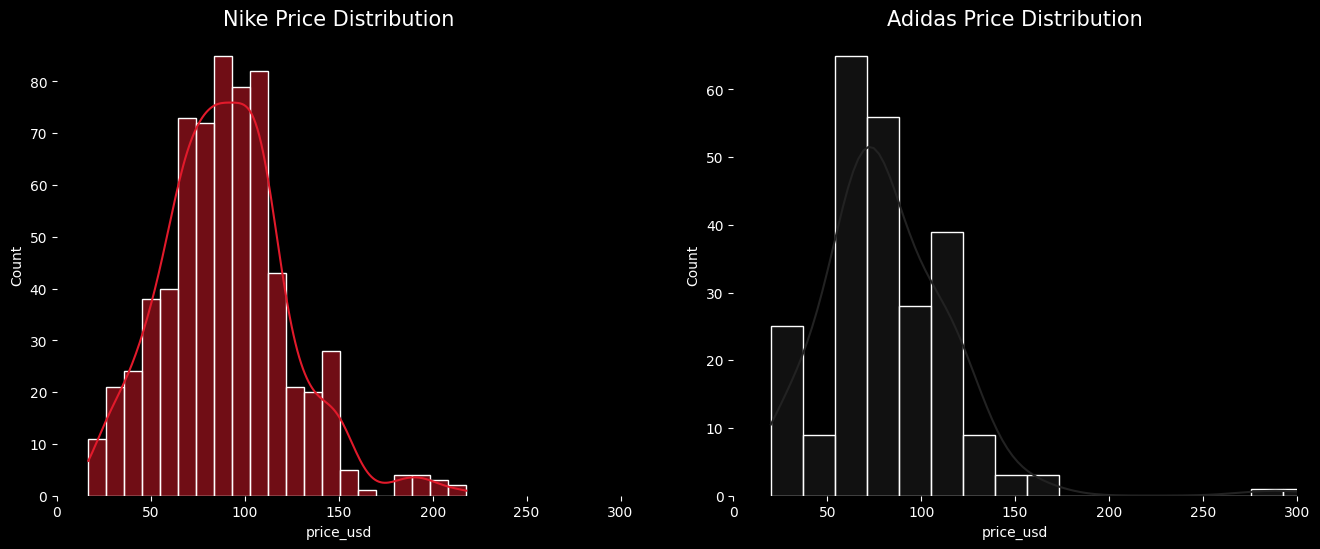

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- 3. THE "KOHEI STYLE" VISUALIZATION ---

# Set up the figure with 2 subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Define colors (Kohei uses Green/Purple, we stick to Brand Colors)
colors = {"nike": "#E11A2B", "adidas": "#222222"}

# Plot 1: Nike Distribution
sns.histplot(
    data=df_final[df_final['brand_final']=='nike'],
    x='price_usd',
    color=colors['nike'],
    kde=True, # Add the curve line
    ax=axes[0]
)
axes[0].set_title('Nike Price Distribution', fontsize=15)
axes[0].set_xlim(0, 300) # Zoom in to relevant prices
axes[0].grid(False) # Clean look

# Plot 2: Adidas Distribution
sns.histplot(
    data=df_final[df_final['brand_final']=='adidas'],
    x='price_usd',
    color=colors['adidas'],
    kde=True,
    ax=axes[1]
)
axes[1].set_title('Adidas Price Distribution', fontsize=15)
axes[1].set_xlim(0, 300)
axes[1].grid(False)

sns.despine(bottom=True, left=True) # Remove borders
plt.show()

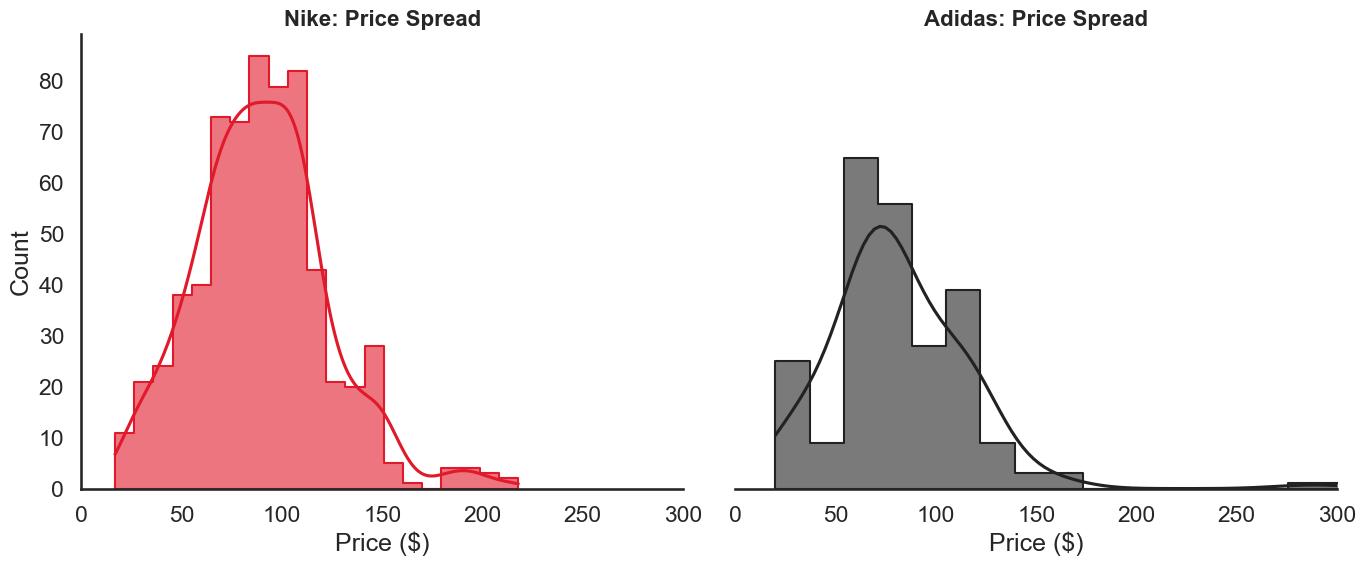

/var/folders/c0/ffhr5hg55hx3vmc9g90tjxzm0000gn/T/ipykernel_57130/2243738229.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


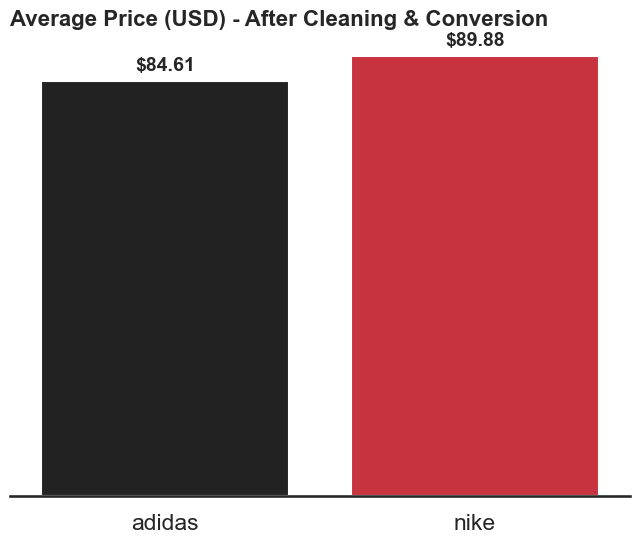

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Set the Clean Theme (The one you liked)
sns.set_theme(style="white", context="talk")
brand_colors = {"nike": "#E11A2B", "adidas": "#222222"}

# --- CHART 1: SIDE-BY-SIDE DISTRIBUTION (The Clean Version) ---
# We use subplots to put them side-by-side, but with white background

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Nike Plot
sns.histplot(
    data=df_final[df_final['brand_final']=='nike'],
    x='price_usd',
    color=brand_colors['nike'],
    kde=True,
    ax=axes[0],
    element="step", # Cleaner "step" look
    alpha=0.6 # Transparency
)
axes[0].set_title("Nike: Price Spread", fontsize=16, fontweight='bold')
axes[0].set_xlabel("Price ($)")
axes[0].set_xlim(0, 300) # Cut off extreme luxury shoes for better view
axes[0].grid(False)
sns.despine(ax=axes[0]) # Remove borders

# Adidas Plot
sns.histplot(
    data=df_final[df_final['brand_final']=='adidas'],
    x='price_usd',
    color=brand_colors['adidas'],
    kde=True,
    ax=axes[1],
    element="step",
    alpha=0.6
)
axes[1].set_title("Adidas: Price Spread", fontsize=16, fontweight='bold')
axes[1].set_xlabel("Price ($)")
axes[1].set_xlim(0, 300)
axes[1].grid(False)
sns.despine(ax=axes[1], left=True) # Remove left border on 2nd plot

plt.tight_layout()
plt.show()


# --- CHART 2: THE BAR CHART (Average Price Comparison) ---
# This is the one with numbers on top

# Calculate new means from our improved data
summary = df_final.groupby('brand_final')['price_usd'].mean().reset_index()

plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=summary,
    x='brand_final',
    y='price_usd',
    palette=brand_colors
)

# Professional Polish
sns.despine(left=True) # Remove left axis line
ax.yaxis.set_visible(False) # Hide Y-axis numbers (redundant)

plt.title("Average Price (USD) - After Cleaning & Conversion", fontsize=16, fontweight='bold', loc='left')
plt.xlabel("") # Remove x-label

# Add the numbers directly on top
for container in ax.containers:
    ax.bar_label(container, fmt='$%.2f', padding=5, fontsize=14, fontweight='bold')

plt.show()